# Project 1: Image Classification

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

## Task 1:  Data Loading (10 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [1]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
print(torch.__version__)
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Data augmentation, tensor conversion and normalization for training
# Just normalization and tensor conversion for testing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Random flip horizontally for data augmentation.
        transforms.RandomCrop(32, padding=4), 
        transforms.ToTensor(),  # Convert to tensor.
        transforms.Normalize(0.5, 0.5) # Normalize by a factor of 0.5 shifting and scaling.
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])
}

# Download (if not downloaded before) & Load CIFAR10
torch.random.manual_seed(0)
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}

##############################################################################################################
# Split train loader into train and valid loaders
valid_size = 0.15
train_indices = np.arange(len(image_datasets['train']))
np.random.shuffle(train_indices)
split = int(len(train_indices) * valid_size)

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices[split:])
valid_sampler = SubsetRandomSampler(train_indices[:split])

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms["test"])

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, sampler=train_sampler, num_workers=4),
    'valid': torch.utils.data.DataLoader(val_dataset, batch_size=64, sampler=valid_sampler, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True, num_workers=4)
}
dataset_sizes = {
    'train': len(train_indices[split:]), 'valid': len(train_indices[:split]), 'test': len(image_datasets['test'])}
##############################################################################################################
class_names = image_datasets['train'].classes

# Ship to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f"The classes found in CIFAR-10 are: {class_names}")

2.0.1+cu118


100%|██████████| 170498071/170498071 [00:14<00:00, 11411370.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
cuda:0
The classes found in CIFAR-10 are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

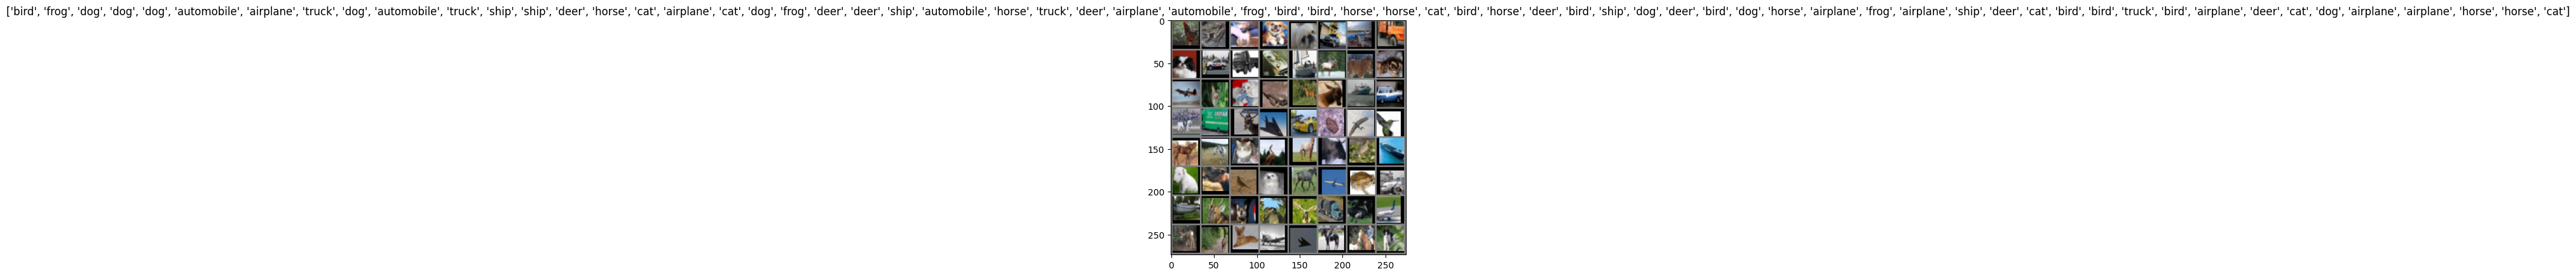

In [2]:
# TODO Task 1:  Run this cell and try to understand the output of each step
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Task 2: Basic Networks (20 points)
1. Create a Fully connected Network (FcNet) using the following layers in the Jupyter Notebook (use the non-linearities wherever necessary):
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the FcNet for **3** epoches and record the training time and accuracy in your final report.

2. Create a Convolutional Network (ConvNet) using the following layers in the Jupyter Notebook (use the non-linearities wherever necessary):
```
ConvNet(
  (conv): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): v, ceil_mode=False)
  (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. Note: You can reuse the conv layers to match the in_features of fc1.

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

### Model training code

In [3]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()

    best_model_wts = model.state_dict()
    best_loss = np.Inf

    train_ls = []
    valid_ls = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) # `preds == labels.data` returns a tensor of Boolean

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_ls.append(epoch_loss)
            else:
                valid_ls.append(epoch_loss)



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Save the model if it have the best validation accuracy
            if phase == 'valid' and epoch_loss < best_loss:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                  best_loss, epoch_loss))
              best_loss = epoch_loss
              best_model_wts = model.state_dict()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), save_path)
    return model, train_ls, valid_ls

### Model test code

In [4]:
def test_model(model, load_path='saved_weight.pth'):
    # load the model weights
    model.load_state_dict(torch.load(load_path))

    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)


            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return

### 1) FC Network

In [ ]:
# 1) Define a Fully Connected Neural Network
# Please advise the Pytorch Documentation and use the appropiate calls

class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 400)
        self.fc3 = nn.Linear(400, 84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

model_ft = FcNet() #Define the model
model_ft = model_ft.to(device)
print(model_ft)

# Define the loss criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Train the model
model_FC , _ , __  = train_model(model_ft, criterion, optimizer, 3)

# Test the model
test_model(model_FC)

FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1/3
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 2.2336 Acc: 0.1828
valid Loss: 2.1184 Acc: 0.2591
Validation loss decreased (inf --> 2.118365).  Saving model ...

Epoch 2/3
----------
train Loss: 2.0113 Acc: 0.2663
valid Loss: 1.9626 Acc: 0.3091
Validation loss decreased (2.118365 --> 1.962641).  Saving model ...

Epoch 3/3
----------
train Loss: 1.9143 Acc: 0.3061
valid Loss: 1.8696 Acc: 0.3375
Validation loss decreased (1.962641 --> 1.869629).  Saving model ...

Training complete in 1m 2s
test Acc: 0.3440
Testing complete in 0m 3s


### 2) CNN

In [ ]:
# 2) Define a Convolutional Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, stride= 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.reshape(-1, 400)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model_ft = ConvNet().to(device) #Define the model
print(model_ft)

# Define the loss criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.05, momentum=0.9)


# Train the model
model_CNN, _, __ = train_model(model_ft, criterion, optimizer, 3)

# Test the model
test_model(model_CNN)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1/3
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 1.8512 Acc: 0.3094
valid Loss: 1.6034 Acc: 0.3996
Validation loss decreased (inf --> 1.603362).  Saving model ...

Epoch 2/3
----------
train Loss: 1.6288 Acc: 0.4008
valid Loss: 1.5238 Acc: 0.4339
Validation loss decreased (1.603362 --> 1.523767).  Saving model ...

Epoch 3/3
----------
train Loss: 1.5804 Acc: 0.4281
valid Loss: 1.5915 Acc: 0.4312

Training complete in 1m 3s
test Acc: 0.4330
Testing complete in 0m 3s


## Task 3.A: Design Your Network (30 points)
Define your own Convolutional Network (MyNet) based on the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) architecture (see Sec. 4.2 for the original architecture used). Here we will experiment with different configurations. Add following modifications and train the Network for **25** epoches. Keep the best settings for each step (for each step, record the training accuracy of the last epoch and test accuracy in your report):

- Modify the number of ResNet blocks per layer: For Simplicity, implement a three-layered ResNet architecture. For each layer, try 1 , 2 and 3 number of ResNet blocks (3 configurations in total). You can choose any of the downsampling methods to match the tensor sizes wherever necessary. Use 2D average pooling layer before applying the final linear layer. For the three layers keep the number of filters 16, 32 and 64 respectively. Follow the ResNet paper to select the kernel size, paddings, optimizer/learning rate, strides, activations and **Batch Normalization** (select a suitable batch size) layers for this task. Print the model summary of the selected model.

#### *Bonus Points: Define a validation set within the training set to monitor underfitting/overfitting after every epoch for each task. (Hint modify dataloaders and/or train_model function)

### Design Your Network

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            #def identity(x):
            #  return x
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x += self.shortcut(identity)
        x = self.relu(x)

        return x

In [ ]:
# Task 3.A: Configuration 1

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 16, 1, blocks = 2)
        self.layer2 = self._make_layer(16, 32, 1, blocks = 2)
        self.layer3 = self._make_layer(32, 64, 1, blocks = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, in_channels, out_channels, stride, blocks):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        in_channels = out_channels

        for i in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = MyNet().to(device) #Define the model
print(model)

# Define the loss criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.9)


# Train the model
model_3A1, _, __ = train_model(model, criterion, optimizer, 25)

# Test the model
test_model(model_3A1)

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride

In [ ]:
# Task 3.A: Configuration 2

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 16, 1, blocks = 1)
        self.layer2 = self._make_layer(16, 32, 1, blocks = 3)
        self.layer3 = self._make_layer(32, 64, 2, blocks = 1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, in_channels, out_channels, stride, blocks):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        in_channels = out_channels

        for i in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = MyNet().to(device) #Define the model
print(model)

# Define the loss criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.85)


# Train the model
model_3A2, _, __ = train_model(model, criterion, optimizer, 25)

# Test the model
test_model(model_3A2)

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32

In [ ]:
# Task 3.A: Configuration 3

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 16, 1, blocks = 1)
        self.layer2 = self._make_layer(16, 32, 2, blocks = 3)
        self.layer3 = self._make_layer(32, 64, 2, blocks = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, in_channels, out_channels, stride, blocks):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        in_channels = out_channels

        for i in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = MyNet().to(device) #Define the model
print(model)

# Define the loss criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.8)


# Train the model
model_3A3, _, __ = train_model(model, criterion, optimizer, 25)

# Test the model
test_model(model_3A3)

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 1.4866 Acc: 0.4471
valid Loss: 1.4833 Acc: 0.4969
Validation loss decreased (inf --> 1.483279).  Saving model ...

Epoch 2/25
----------
train Loss: 1.0587 Acc: 0.6204
valid Loss: 1.5047 Acc: 0.5281

Epoch 3/25
----------
train Loss: 0.8868 Acc: 0.6861
valid Loss: 1.0255 Acc: 0.6521
Validation loss decreased (1.483279 --> 1.025507).  Saving model ...

Epoch 4/25
----------
train Loss: 0.7804 Acc: 0.7253
valid Loss: 1.0038 Acc: 0.6677
Validation loss decreased (1.025507 --> 1.003798).  Saving model ...

Epoch 5/25
----------
train Loss: 0.7161 Acc: 0.7505
valid Loss: 0.7210 Acc: 0.7511
Validation loss decreased (1.003798 --> 0.720976).  Saving model ...

Epoch 6/25
----------
train Loss: 0.6591 Acc: 0.7711
valid Loss: 0.7522 Acc: 0.7476

Epoch 7/25
----------
train Loss: 0.6150 Acc: 0.7858
valid Loss: 0.7673 Acc: 0.7459

Epoch 8/25
----------
train Loss: 0.5810 Acc: 0.7995
valid Loss: 0.7879 Acc: 0.7539

Epoch 9/25
----------
train Loss: 0.5639 Acc: 0.8060
valid Loss: 0.6576

## Task 3.B: Design Your Network (10 points)
Using your best network/model from Task 3.A, please do the following modifications:

- Use Dropout: Toggle **Dropout** in fully connected layers. Does it improve the validation/test accuracy and/or avoid overfitting?

In [ ]:
# Task 3.B:

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 16, 1, blocks = 1)
        self.layer2 = self._make_layer(16, 32, 2, blocks = 3)
        self.layer3 = self._make_layer(32, 64, 2, blocks = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, in_channels, out_channels, stride, blocks):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        in_channels = out_channels

        for i in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = MyNet().to(device) #Define the model
print(model)

# Define the loss criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.8)


# Train the model
model_3B, _, __ = train_model(model, criterion, optimizer, 25)

# Test the model
test_model(model_3B)

MyNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 1.6236 Acc: 0.3950
valid Loss: 1.6064 Acc: 0.4184
Validation loss decreased (inf --> 1.606382).  Saving model ...

Epoch 2/25
----------
train Loss: 1.1830 Acc: 0.5742
valid Loss: 1.5564 Acc: 0.5008
Validation loss decreased (1.606382 --> 1.556397).  Saving model ...

Epoch 3/25
----------
train Loss: 0.9864 Acc: 0.6497
valid Loss: 1.0644 Acc: 0.6323
Validation loss decreased (1.556397 --> 1.064376).  Saving model ...

Epoch 4/25
----------
train Loss: 0.8632 Acc: 0.6987
valid Loss: 0.9337 Acc: 0.6849
Validation loss decreased (1.064376 --> 0.933690).  Saving model ...

Epoch 5/25
----------
train Loss: 0.7806 Acc: 0.7290
valid Loss: 0.7553 Acc: 0.7427
Validation loss decreased (0.933690 --> 0.755270).  Saving model ...

Epoch 6/25
----------
train Loss: 0.7188 Acc: 0.7524
valid Loss: 0.7175 Acc: 0.7603
Validation loss decreased (0.755270 --> 0.717496).  Saving model ...

Epoch 7/25
----------
train Loss: 0.6630 Acc: 0.7739
valid Loss: 0.7562 Acc: 0.7501

Epoch 8/25
-------

Q) Does it improve the validation/test accuracy and/or avoid overfitting?

A)Yes for overfitting. For test accuracy it become a little bit lower in our model.

## Task 4: The Optimizer (20 points)
Keeping the best settings of Task 4, try 2 different optimizers (SGD and ADAM) with 3 different learning rates (0.01, 0.1, 1.) . Keep the other parameters as default. Plot the loss curves ( Training step vs Training loss ) for the 6 cases (Hint: Modify the train_model fuction). How does the learning rate affect the training?

#### *Bonus Points: Define a validation set within the training set to examine the best model among the above cases. (Hint modify dataloaders and/or train_model function)

In [6]:
# Define a Convolutional Neural Network
class MyFinalNet(nn.Module):
    def __init__(self):
        super(MyFinalNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 16, 1, blocks = 1)
        self.layer2 = self._make_layer(16, 32, 2, blocks = 3)
        self.layer3 = self._make_layer(32, 64, 2, blocks = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, in_channels, out_channels, stride, blocks):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        in_channels = out_channels

        for i in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:


# The Optimizers

lr_list = [0.01, 0.1, 1]
optimizer_name = ['SGD','Adam']
train_losses = []
valid_losses = []
models6 = []

for lr in lr_list:
    for op in optimizer_name:
        model_ft = MyFinalNet()
        model_ft = model_ft.to(device)
        # The loss criterion
        criterion = nn.CrossEntropyLoss()
        
        if op == 'SGD':
            optimizer = optim.SGD(model_ft.parameters(), lr=lr)
        else:
            optimizer = optim.Adam(model_ft.parameters(), lr=lr)

        print("#######################################################################################")
        print("Optimizer: {}, Learning rate: {}".format(op, lr))

        model_4, train_loss, valid_loss = train_model(model_ft, criterion, optimizer, num_epochs=25)
        models6.append(model_4)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Test the model
        test_model(model_4)

#######################################################################################
Optimizer: SGD, Learning rate: 0.01
Epoch 1/25
----------
train Loss: 1.8339 Acc: 0.3075
valid Loss: 2.2270 Acc: 0.2915
Validation loss decreased (inf --> 2.227002).  Saving model ...

Epoch 2/25
----------
train Loss: 1.5045 Acc: 0.4448
valid Loss: 1.6827 Acc: 0.4081
Validation loss decreased (2.227002 --> 1.682658).  Saving model ...

Epoch 3/25
----------
train Loss: 1.3485 Acc: 0.5112
valid Loss: 2.2080 Acc: 0.3383

Epoch 4/25
----------
train Loss: 1.2280 Acc: 0.5581
valid Loss: 1.6171 Acc: 0.4515
Validation loss decreased (1.682658 --> 1.617077).  Saving model ...

Epoch 5/25
----------
train Loss: 1.1380 Acc: 0.5918
valid Loss: 3.8082 Acc: 0.2768

Epoch 6/25
----------
train Loss: 1.0688 Acc: 0.6179
valid Loss: 1.1488 Acc: 0.5937
Validation loss decreased (1.617077 --> 1.148754).  Saving model ...

Epoch 7/25
----------
train Loss: 1.0076 Acc: 0.6388
valid Loss: 1.8662 Acc: 0.4577

Epoch 8/25

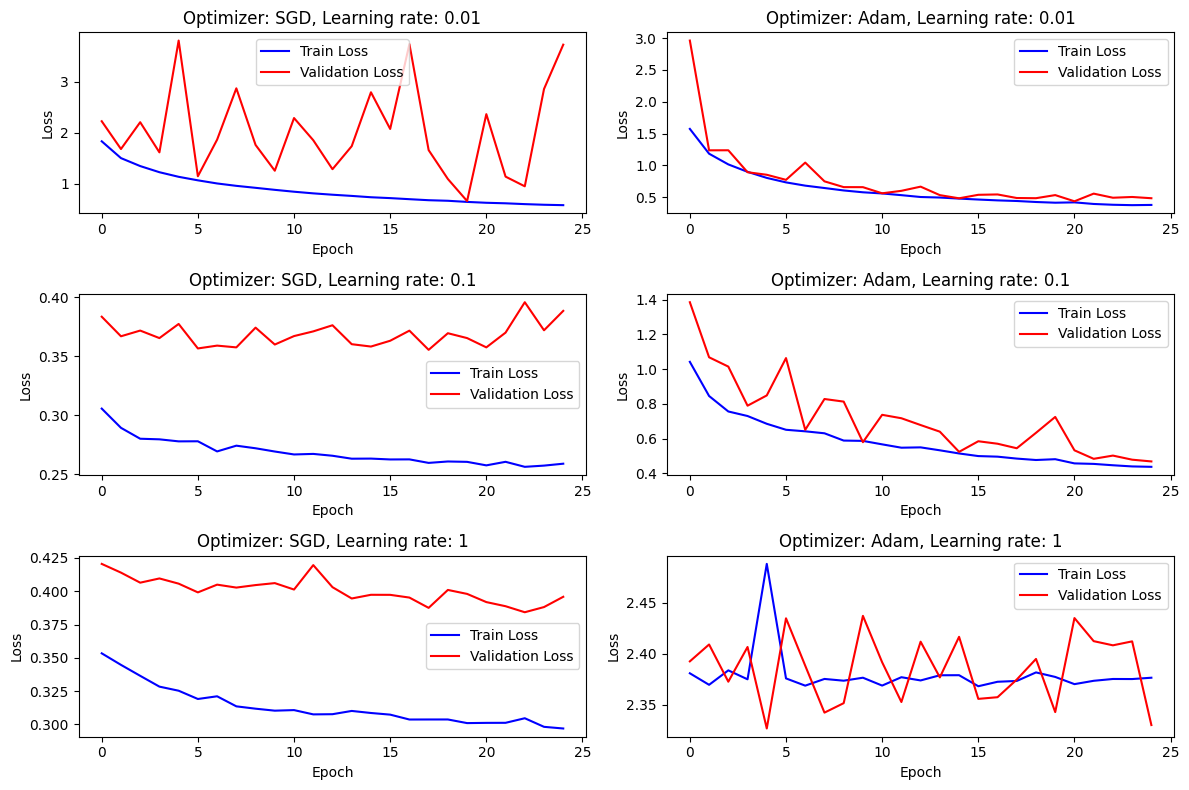

In [ ]:
num_lr = len(lr_list)
num_optimizers = len(optimizer_name)

fig, axs = plt.subplots(num_lr, num_optimizers, figsize=(12, 8))
c = 0
for lr in range(num_lr):
    for op in range(num_optimizers):
      ax = axs[lr, op]
      # Plot the train and validation losses
      ax.plot(train_losses[c], label='Train Loss', color='blue')
      ax.plot(valid_losses[c], label='Validation Loss', color='red')
      c += 1
      # labels and titles
      ax.set_xlabel('Epoch')
      ax.set_ylabel('Loss')
      ax.set_title('Optimizer: {}, Learning rate: {}'.format(optimizer_name[op], lr_list[lr]))
      ax.legend() # Add legend

plt.tight_layout()
plt.show()

Q) How does the learning rate affect the training?

A) Increasing the learning rate too much couses an overfitting in SGD.
For ADAM optimizer, both training and validation losses increased.

### Display model predictions

In [ ]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad(): # ensure no gradient will be computed.
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # to get the class with the highest predicted probability.

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

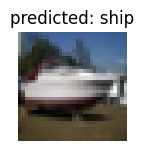

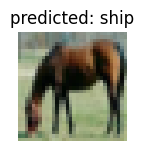

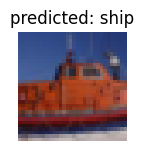

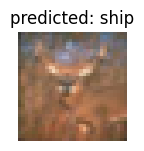

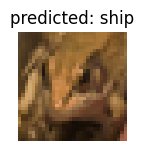

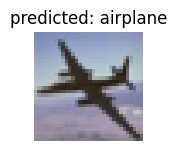

In [ ]:
# TODO Display your best model predictions
display_predictions(models6[2]) # Optimizer: SGD, Learning rate: 0.1
#display_predictions(model_CNN)

## Task 5: Feature Visualization (5 points)
Visualize feature maps of the first and the last convolutional layer of your final network using **cifar_example.jpg** as input image. Show the visualization in the report.

#### First layer activations
<img src="https://i.imgur.com/kGB9AuP.png" width="400" align="left">

#### Last layer activations

<img src="https://i.imgur.com/qelH05X.png" width="400" align="left">

In [ ]:
#Task 5: Visualization

In [47]:
class MyFinalNet(nn.Module):
    def __init__(self):
        super(MyFinalNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 16, 1, blocks = 1)
        self.layer2 = self._make_layer(16, 32, 2, blocks = 3)
        self.layer3 = self._make_layer(32, 64, 2, blocks = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, in_channels, out_channels, stride, blocks):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        in_channels = out_channels

        for i in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        out1 = x  # Save the output after the first layer

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        out2 = x  # Save the output after the last layer

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x, out1, out2

In [8]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [48]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [52]:
inputs = transfer_single_img_to_tensor('./cifar_example.jpg') # Loads an image and normalizes it
model_ft = MyFinalNet()
model_ft.eval()

# Move the model and inputs to CPU
model_ft = model_ft.to('cpu')
inputs = inputs.to('cpu')

with torch.no_grad():
    # TODO: Retrive the first and the last layer feature maps of your best model. (Hint: Move back to CPU)
    final_output, out1, out2 = model_ft(inputs)
    #print(out1[0].size())
    out1 = out1[0].unsqueeze(1) # Select the feature maps of the first image in the batch
    #print(out1.size())
    out2 = out2[0].unsqueeze(1)

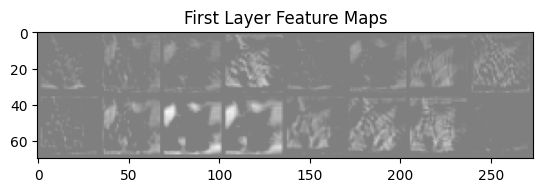

In [50]:
# Visualize the feature maps
out1 = torchvision.utils.make_grid(out1)
feature_imshow(out1, title='First Layer Feature Maps')

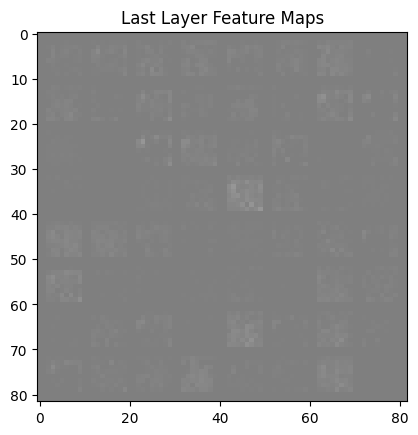

In [51]:
out2 = torchvision.utils.make_grid(out2)
feature_imshow(out2, title='Last Layer Feature Maps')

## Task 6: Weight Visualization (5 points)
Visualize weights of convolutional layers of your final network. Show the visualization in the report.

In [ ]:
# TODO: Task 6
# Hint:
# 1) What is the size of each weight (filter) tensor?
# 2) Normalize weight values to [0, 1]
# 3) Each subfigure should be of size [kernel_size, kernel_size]
# 4) How many subfigures in total?

<ipython-input-17-17e607b027d2>:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(conv_layers), num_filters, subfigure_count + 1)
<ipython-input-17-17e607b027d2>:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


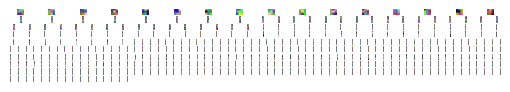

In [17]:
def visualize_weights(model):
    conv_layers = [model.conv1] + list(model.layer1.modules()) + list(model.layer2.modules()) + list(model.layer3.modules())
    subfigure_count = 0

    for i, layer in enumerate(conv_layers):
        if isinstance(layer, nn.Conv2d):
            weights = layer.weight.data
            num_filters, _, kernel_size, _ = weights.size() 
            #print(layer); print(weights.size()); print()
            for j in range(num_filters):
                filter_weights = weights[j].detach().cpu().numpy()

                # Normalize weights to [0, 1]
                min_val = np.min(filter_weights)
                max_val = np.max(filter_weights)
                normalized_weights = (filter_weights - min_val) / (max_val - min_val)

                # Plot the subfigure
                plt.subplot(len(conv_layers), num_filters, subfigure_count + 1)
                plt.imshow(normalized_weights, cmap='gray')
                plt.axis('off')

                subfigure_count += 1

    plt.tight_layout()
    plt.show()

# Call the function to visualize the weights
model_ft = MyFinalNet()
visualize_weights(model_ft)